In [1]:
from timeit import default_timer as timer
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

# standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssms  # where state-space models are defined
from particles.collectors import Moments

# d=10

In [2]:
def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.
    Parameters
    ----------
    su: (M,) ndarray
    M sorted variates (i.e. M ordered points in [0,1]).
    W: (N,) ndarray
    a vector of N normalized weights (>=0 and sum to one)
    Returns
    -------
    A: (M,) ndarray
    a vector of M indexes in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, 'int')
    for n in range(M):
        while su[n] > s:
            j += 1
            s += W[j]
        A[n] = j
    return A

In [3]:
from numpy import random
def stratified(M, W):
    su = (random.rand(M) + np.arange(M)) / M
    return inverse_cdf(su, W)

def systematic(M, W):
    su = (random.rand(1) + np.arange(M)) / M
    return inverse_cdf(su, W)

In [4]:
def uniform_spacings(N):
    z = np.cumsum(-np.log(random.rand(N + 1)))
    return z[:-1] / z[-1]

def multinomial(M, W):
    return inverse_cdf(uniform_spacings(M), W)

In [5]:
def multinomial(M, W):
    return np.searchsorted(np.cumsum(W), random.rand(M))

In [6]:
d = 100000
n_rand = np.random.uniform(size=d)
M = d
W = n_rand / np.sum(n_rand)

In [7]:
start_time = timer()
stratified(M, W)
print(f'\n{timer() - start_time} seconds for d={d}')


0.06244583614170551 seconds for d=100000


In [8]:
# Test the resampling methods on a state space model

class ThetaLogistic(ssms.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'tau0':.15, 'tau1':.12, 'tau2':.1, 'sigmaX': 0.47, 'sigmaY': 0.39}

    def PX0(self):  # Distribution of X_0
        return dists.Normal()

    def f(self, x):
        return (x + self.tau0 - self.tau1 * np.exp(self.tau2 * x))

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.Normal(loc=self.f(xp), scale=self.sigmaX)

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x, and X_{t-1}=xp
        return dists.Normal(loc=x, scale=self.sigmaY)

In [9]:
# no. of time steps
T = 100

## Multinomial

In [10]:
# Store results for Multonomial Sampling
multinomial = []
for N in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
          19000, 20000, 21000, 22000, 23000, 24000, 25000,]:
    w_d10 = []
    x_d10 = []
    x_d10_mean = []
    x_d10_var = []
    y_d10 = []
    
    start_time = timer()
    np.random.seed(N)
    for i in range(100):
        np.random.seed(i)
        bear1 = ThetaLogistic()
        x1, y1 = bear1.simulate(T)

        fk1 = ssms.Bootstrap(ssm=bear1, data=y1)
        alg1 = particles.SMC(fk=fk1, N=N, collect=[Moments()],
                             resampling='multinomial', store_history=1)
        alg1.run()

        w_d10.append(alg1.hist.wgts[-1].W)
        x_d10.append(x1[-1].ravel())
        y_d10.append(y1[-1].ravel())
        x_d10_mean.append([m['mean'] for m in alg1.summaries.moments][-1])
        x_d10_var.append([m['var'] for m in alg1.summaries.moments][-1])
    
    time = (timer() - start_time)/100

    dist_d10 = np.array([np.linalg.norm(np.array(x_d10[i]) - np.array(x_d10_mean[i]), ord=2)
                for i in range(100)])
    dist_d10_sq = np.square(dist_d10)
    
    multinomial.append([N, time, np.mean(dist_d10_sq)])
    print(N, ',', time, ",", np.mean(dist_d10_sq))

1000 , 0.047827701182104644 , 0.09475045294894928
2000 , 0.05591769790276885 , 0.09532261092067124
3000 , 0.06875707023777068 , 0.09605841512069035
4000 , 0.08167616294696928 , 0.09493590110832029
5000 , 0.09471701751928777 , 0.09586873045255118
6000 , 0.1073403662396595 , 0.09571163320016922
7000 , 0.12015984972007572 , 0.09544665814662698
8000 , 0.13293346586171537 , 0.0952657754756449
9000 , 0.1460374412499368 , 0.09595340721606073
10000 , 0.1586099258530885 , 0.0956807144940418
11000 , 0.17126862207893281 , 0.09531141763382443
12000 , 0.18409737458918243 , 0.0952991968287103
13000 , 0.19707484874874354 , 0.09539569956627345
14000 , 0.2095360057381913 , 0.09642867263324803
15000 , 0.2225266849435866 , 0.09609949099063791
16000 , 0.2351884447131306 , 0.09576059693911533
17000 , 0.24764590903650968 , 0.09602971916958813
18000 , 0.26021655861288306 , 0.09562966301277669
19000 , 0.2728287352574989 , 0.09564188280342595
20000 , 0.28600057054311034 , 0.09586928051278944
21000 , 0.29880333

## Stratified Resampling

In [13]:
# Store results for Multonomial Sampling
stratified = []
for N in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
          19000, 20000, 21000, 22000, 23000, 24000, 25000]:
    w2_d10 = []
    x2_d10 = []
    x2_d10_mean = []
    x2_d10_var = []
    y2_d10 = []
    
    start_time = timer()
    np.random.seed(N)
    for i in range(100):
        np.random.seed(i)
        bear2 = ThetaLogistic()
        x2, y2 = bear2.simulate(T)

        fk2 = ssms.Bootstrap(ssm=bear2, data=y2)
        alg2 = particles.SMC(fk=fk2, N=N, collect=[Moments()],
                             resampling='stratified', store_history=1)
        alg2.run()

        w2_d10.append(alg2.hist.wgts[-1].W)
        x2_d10.append(x2[-1].ravel())
        y2_d10.append(y2[-1].ravel())
        x2_d10_mean.append([m['mean'] for m in alg2.summaries.moments][-1])
        x2_d10_var.append([m['var'] for m in alg2.summaries.moments][-1])
    
    time = (timer() - start_time)/100

    dist2_d10 = np.array([np.linalg.norm(np.array(x2_d10[i]) - np.array(x2_d10_mean[i]), ord=2)
                for i in range(100)])
    
    stratified.append([N, time, np.mean(dist_d10_sq)])
    print(N, ',', time, ",", np.mean(dist2_d10))

1000 , 0.04162862229160964 , 0.2596035505199382
2000 , 0.052379209380596876 , 0.2588481234855146
3000 , 0.06363631501793861 , 0.25800854406547163
4000 , 0.07502205729018897 , 0.2591058192736398
5000 , 0.086198372063227 , 0.2591852988549989
6000 , 0.09741267323959618 , 0.2592416009639861
7000 , 0.10871968140825629 , 0.25893358821001705
8000 , 0.11983420156873763 , 0.2580938735947144
9000 , 0.1315448947995901 , 0.2586964056925265
10000 , 0.1428364969883114 , 0.2579094179988992
11000 , 0.15407923355232925 , 0.25891557957477923
12000 , 0.1652542530465871 , 0.2579434788897982
13000 , 0.17640141784679145 , 0.2580883306263763
14000 , 0.18764744399115443 , 0.258445847341208
15000 , 0.19904217614792288 , 0.2582862911305586
16000 , 0.21000898573081941 , 0.25772876917122733
17000 , 0.22133948650211097 , 0.25892697813236976
18000 , 0.23177035009954125 , 0.25820282576992404
19000 , 0.24276839173864573 , 0.25868640357517886
20000 , 0.2536701373104006 , 0.2583759277016821
21000 , 0.265295994291082 , 

## Systematic Resampling

In [14]:
# Store results for Systematic Sampling
systematic = []
for N in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
          19000, 20000, 21000, 22000, 23000, 24000, 25000]:
    w3_d10 = []
    x3_d10 = []
    x3_d10_mean = []
    x3_d10_var = []
    y3_d10 = []
    
    start_time = timer()
    np.random.seed(N)
    for i in range(100):
        np.random.seed(i)
        bear3 = ThetaLogistic()
        x3, y3 = bear3.simulate(T)

        fk3 = ssms.Bootstrap(ssm=bear3, data=y3)
        alg3 = particles.SMC(fk=fk3, N=N, collect=[Moments()],
                             resampling='systematic', store_history=1)
        alg3.run()

        w3_d10.append(alg3.hist.wgts[-1].W)
        x3_d10.append(x3[-1].ravel())
        y3_d10.append(y3[-1].ravel())
        x3_d10_mean.append([m['mean'] for m in alg3.summaries.moments][-1])
        x3_d10_var.append([m['var'] for m in alg3.summaries.moments][-1])
    
    time = (timer() - start_time)/100

    dist3_d10 = np.array([np.linalg.norm(np.array(x3_d10[i]) - np.array(x3_d10_mean[i]), ord=2)
                for i in range(100)])
    
    systematic.append([N, time, np.mean(dist_d10_sq)])
    print(N, ',', time, ",", np.mean(dist3_d10))

1000 , 0.040643289890140294 , 0.25726958821351487
2000 , 0.051838150518015026 , 0.25922781193929123
3000 , 0.06293795130215585 , 0.25876486850509794
4000 , 0.0737761847814545 , 0.259097660806232
5000 , 0.08455199506133795 , 0.2591738088779502
6000 , 0.09520825214684009 , 0.25901752558608326
7000 , 0.10638947627972811 , 0.2587612566028821
8000 , 0.11716947892680764 , 0.2584124476054074
9000 , 0.1283301205234602 , 0.2585418490224514
10000 , 0.13923509779851884 , 0.2585591237350087
11000 , 0.15030792898032813 , 0.2581716327546828
12000 , 0.1611075564706698 , 0.2586062617045777
13000 , 0.1717375961598009 , 0.25841393305067756
14000 , 0.18258113861083985 , 0.2585942842396005
15000 , 0.19342910713050515 , 0.25806057788444275
16000 , 0.20370288548059762 , 0.25848027690463454
17000 , 0.21477266618050636 , 0.25825237739546486
18000 , 0.2255007482180372 , 0.2588228860850379
19000 , 0.23589379305951297 , 0.2580968760053803
20000 , 0.24661166312173008 , 0.25870656637784
21000 , 0.257674771300517 ,

## Residual Resampling

In [15]:
# Store results for Residual Resampling
residual = []
for N in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
          19000, 20000, 21000, 22000, 23000, 24000, 25000]:
    w4_d10 = []
    x4_d10 = []
    x4_d10_mean = []
    x4_d10_var = []
    y4_d10 = []
    
    start_time = timer()
    np.random.seed(N)
    for i in range(100):
        np.random.seed(i)
        bear4 = ThetaLogistic()
        x4, y4 = bear4.simulate(T)

        fk4 = ssms.Bootstrap(ssm=bear4, data=y1)
        alg4 = particles.SMC(fk=fk4, N=N, collect=[Moments()],
                             resampling='residual', store_history=1, )
        alg4.run()

        w4_d10.append(alg4.hist.wgts[-1].W)
        x4_d10.append(x4[-1].ravel())
        y4_d10.append(y4[-1].ravel())
        x4_d10_mean.append([m['mean'] for m in alg4.summaries.moments][-1])
        x4_d10_var.append([m['var'] for m in alg4.summaries.moments][-1])
    
    time = (timer() - start_time)/100

    dist4_d10 = np.array([np.linalg.norm(np.array(x4_d10[i]) - np.array(x4_d10_mean[i]), ord=2)
                for i in range(100)])
    
    residual.append([N, time, np.mean(dist_d10_sq)])
    print(N, ',', time, ",", np.mean(dist4_d10))

1000 , 0.043248839587904514 , 2.388289056748706
2000 , 0.05513213564641774 , 2.3934801873814364
3000 , 0.06682665735948831 , 2.3911063437457183
4000 , 0.07829995748121292 , 2.391629287597866
5000 , 0.08995798578020185 , 2.391385926081753
6000 , 0.10161111971363425 , 2.3900348568493275
7000 , 0.11324671287089587 , 2.390920229617956
8000 , 0.12394204549957066 , 2.3910507727732444
9000 , 0.13595694998744876 , 2.392159019960981
10000 , 0.1471862743422389 , 2.391510157847301
11000 , 0.1586998671805486 , 2.390874232182002
12000 , 0.17015134321060033 , 2.39121860780844
13000 , 0.1823303802171722 , 2.391628410727015
14000 , 0.19418700132053346 , 2.3916448092704963
15000 , 0.20550560217816383 , 2.390842876946867
16000 , 0.21696001938078552 , 2.391303273943039
17000 , 0.22843371064867823 , 2.3912668646875077
18000 , 0.23929375402163713 , 2.3913689266105065
19000 , 0.2505463715875521 , 2.391364930524183
20000 , 0.2619319026218727 , 2.392004673110293
21000 , 0.27341092117130755 , 2.391537723146573

### Runtime plots

In [17]:
columns = ['N', 'time', 'squared_error']
df_multinomial = pd.DataFrame(multinomial, columns=columns)
df_stratified = pd.DataFrame(stratified, columns=columns)
df_systematic = pd.DataFrame(systematic, columns=columns)
df_residual = pd.DataFrame(reisdual, columns=columns)    

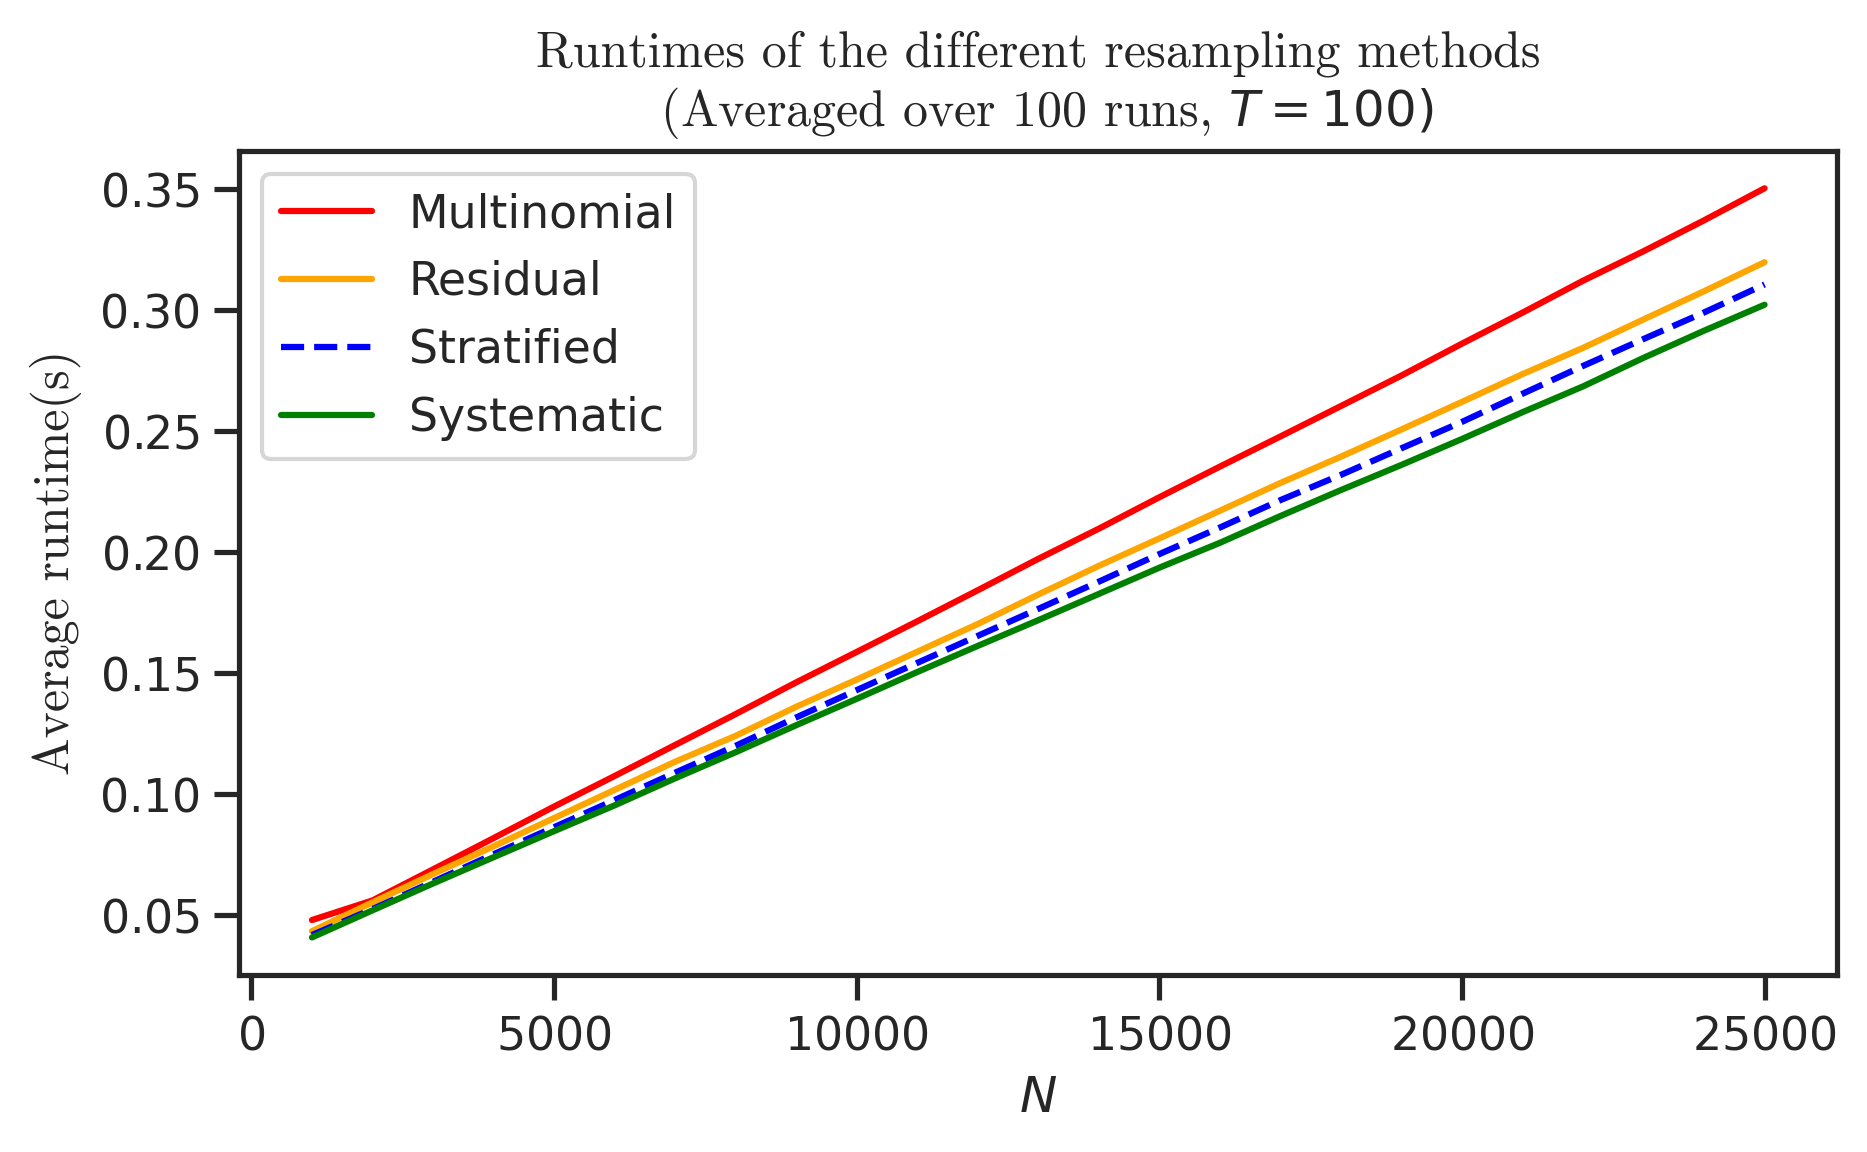

In [18]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter


# Set the Seaborn style (optional)
sns.set(style="ticks")

# Create scatter plots for u, v, w against x
plt.figure(figsize=(6.4, 4), dpi=300)

sns.lineplot(x='N', y='time', data=df_multinomial, label=r'Multinomial', color='red', marker=None, linestyle='-')
sns.lineplot(x='N', y='time', data=df_residual, label=r'Residual', color='orange', marker=None, linestyle='-')
sns.lineplot(x='N', y='time', data=df_stratified, label=r'Stratified', color='blue', marker=None, linestyle='--')
sns.lineplot(x='N', y='time', data=df_systematic, label=r'Systematic', color='green', marker=None, linestyle='-')

#plt.xscale('log')

plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))

# Add labels and title
plt.xlabel(r'$N$', fontname='cmr10')
plt.ylabel(r'Average runtime(s)', fontname='cmr10')
plt.title('Runtimes of the different resampling methods\n (Averaged over 100 runs, $T=100)$', fontname='cmr10')

plt.tight_layout()
plt.savefig("2.rt_resample.pdf", format="pdf", bbox_inches="tight")
plt.show()
# Show the plot
plt.show()

## Log likelihood